In [1]:
import torch
import lightning.pytorch as pl
from datapile import FastPMPile, HuggingfaceLoader, CSVHDF5DataModule
from model import Lpt2NbodyNetLightning
import yaml
import argparse
import os

def load_config(config_file):
    with open(config_file, 'r') as file:
        config = yaml.safe_load(file)
    return config

/home/user/ckwan1/.conda/envs/d3m/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
path="/home/user/ckwan1/ml_project/field2field/configs/styledunet.yaml"
config = load_config(path)
config['model']['num_layers'] = 4
config['model']['base_filters']  = 4
model = Lpt2NbodyNetLightning(**config['model'])

In [4]:
config['data']['batch_size'] = 1
config['data']['num_workers'] = 1
data = HuggingfaceLoader(**config['data'])
data.setup("validation")
val_iter = iter(data.val_dataloader())
batch = next(val_iter)

In [12]:
path="/home/user/ckwan1/ml_project/field2field/configs/32/naf_finetune_s8.yaml"
config = load_config(path)
config['data']['batch_size'] = 1
config['data']['num_workers'] = 1
data = CSVHDF5DataModule(**config['data'])
data.setup("validation")
val_iter = iter(data.val_dataloader())
batch = next(val_iter)

In [13]:
batch[2]

tensor([[0.0000, 0.0000, 0.0000, 0.6884, 0.0000]])

In [2]:
path1="/home/user/ckwan1/ml_project/field2field/configs/32/naf_finetune_s8.yaml"
config1 = load_config(path1)
model = Lpt2NbodyNetLightning(**config1['model'])
post_ckpt = torch.load("/home/user/ckwan1/ml_project/field2field/new_checkpoints/naf_finetune_dummy/best-checkpoint-epoch=99.ckpt", map_location="cpu")

model.load_state_dict(post_ckpt['state_dict'])

/tmp/ipykernel_3739579/675966113.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  post_ckpt = torch.load("/home/user/ckwan1/ml_project/field2field/new_checkpoints/naf_fin

<All keys matched successfully>

In [3]:

pt_ckpt = torch.load("/home/user/ckwan1/ml_project/field2field/new_checkpoints/naf_base_sca_denoise_32/best-checkpoint-epoch=2303_c.ckpt", map_location="cpu")
pre_model = Lpt2NbodyNetLightning(**config1['model'])

pre_model.load_state_dict(pt_ckpt['state_dict'],strict=False)

/tmp/ipykernel_3739579/2805961183.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_ckpt = torch.load("/home/user/ckwan1/ml_project/field2field/new_checkpoints/naf_base

_IncompatibleKeys(missing_keys=['model.encoders.0.0.mod_conv1.style_weight', 'model.encoders.0.0.mod_conv1.style_bias', 'model.encoders.0.0.mod_conv1.weight', 'model.encoders.0.0.mod_conv1.bias', 'model.encoders.0.0.mod_conv2.style_weight', 'model.encoders.0.0.mod_conv2.style_bias', 'model.encoders.0.0.mod_conv2.weight', 'model.encoders.0.0.mod_conv2.bias', 'model.encoders.0.0.mod_conv3.style_weight', 'model.encoders.0.0.mod_conv3.style_bias', 'model.encoders.0.0.mod_conv3.weight', 'model.encoders.0.0.mod_conv3.bias', 'model.encoders.0.0.sca_conv.style_weight', 'model.encoders.0.0.sca_conv.style_bias', 'model.encoders.0.0.sca_conv.weight', 'model.encoders.0.0.sca_conv.bias', 'model.encoders.0.0.mod_conv4.style_weight', 'model.encoders.0.0.mod_conv4.style_bias', 'model.encoders.0.0.mod_conv4.weight', 'model.encoders.0.0.mod_conv4.bias', 'model.encoders.0.0.mod_conv5.style_weight', 'model.encoders.0.0.mod_conv5.style_bias', 'model.encoders.0.0.mod_conv5.weight', 'model.encoders.0.0.mod_c

In [ ]:
for (name, param_pre) in pre_model.named_parameters():
    param_post = dict(model.named_parameters())[name]
    
    # Skip style parameters (they are allowed to change)
    if 'style_weight' in name or 'style_bias' in name:
        continue

    if not torch.allclose(param_pre, param_post, atol=1e-6):
        print(f"❌ Weight changed: {name}")
    else:
        print(f"✅ Weight unchanged: {name}")

✅ Weight unchanged: model.intro.weight
✅ Weight unchanged: model.intro.bias
✅ Weight unchanged: model.encoders.0.0.beta
✅ Weight unchanged: model.encoders.0.0.gamma
❌ Weight changed: model.encoders.0.0.mod_conv1.weight
✅ Weight unchanged: model.encoders.0.0.mod_conv1.bias
❌ Weight changed: model.encoders.0.0.mod_conv2.weight
✅ Weight unchanged: model.encoders.0.0.mod_conv2.bias
❌ Weight changed: model.encoders.0.0.mod_conv3.weight
✅ Weight unchanged: model.encoders.0.0.mod_conv3.bias
❌ Weight changed: model.encoders.0.0.sca_conv.weight
✅ Weight unchanged: model.encoders.0.0.sca_conv.bias
❌ Weight changed: model.encoders.0.0.mod_conv4.weight
✅ Weight unchanged: model.encoders.0.0.mod_conv4.bias
❌ Weight changed: model.encoders.0.0.mod_conv5.weight
✅ Weight unchanged: model.encoders.0.0.mod_conv5.bias
✅ Weight unchanged: model.encoders.0.0.norm1.weight
✅ Weight unchanged: model.encoders.0.0.norm1.bias
✅ Weight unchanged: model.encoders.0.0.norm2.weight
✅ Weight unchanged: model.encoders.

: 

In [ ]:
batch[2].shape

torch.Size([1, 5])

: 

In [ ]:
input_shape = (2, 3, 64, 64, 64)  
output_shape = (2, 3, 64, 64, 64) 
style_shape = (2, 5) 
verify_model(model, input_shape, output_shape, style_shape)

✅ Forward pass completed successfully.
Output shape: torch.Size([2, 3, 64, 64, 64])
✅ Backward pass completed successfully.

🔍 Parameter gradient check:
✔️  'model.encoders.0.0.conv.style_weight': grad norm = 0.0027
✔️  'model.encoders.0.0.conv.style_bias': grad norm = 0.0018
✔️  'model.encoders.0.0.conv.weight': grad norm = 0.0378
✔️  'model.encoders.0.0.conv.bias': grad norm = 0.0000
✔️  'model.encoders.0.0.bn.weight': grad norm = 0.0034
✔️  'model.encoders.0.0.bn.bias': grad norm = 0.0018
✔️  'model.encoders.1.0.conv.style_weight': grad norm = 0.0042
✔️  'model.encoders.1.0.conv.style_bias': grad norm = 0.0016
✔️  'model.encoders.1.0.conv.weight': grad norm = 0.0510
✔️  'model.encoders.1.0.conv.bias': grad norm = 0.0000
✔️  'model.encoders.1.0.bn.weight': grad norm = 0.0017
✔️  'model.encoders.1.0.bn.bias': grad norm = 0.0015
✔️  'model.encoders.1.1.conv.style_weight': grad norm = 0.0055
✔️  'model.encoders.1.1.conv.style_bias': grad norm = 0.0029
✔️  'model.encoders.1.1.conv.weight

: 

In [2]:
import torch
import torch.nn as nn

def verify_model(model, input_shape, output_shape=None, style_shape=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Verify that a model can successfully complete forward and backward passes,
    and detect inactive modules and parameters.
    
    Args:
        model: The PyTorch model to verify
        input_shape: Shape of input tensor (including batch size)
        output_shape: Expected output shape (for loss calculation)
        style_shape: Shape of the style tensor if required
        device: Device to run verification on
    """
    model = model.to(device)
    model.train()

    # Track modules that were activated in the forward pass
    visited_modules = set()

    def forward_hook(module, input, output):
        visited_modules.add(module)

    # Register hooks on all submodules
    hooks = []
    for module in model.modules():
        if not isinstance(module, nn.Sequential) and module != model:
            hooks.append(module.register_forward_hook(forward_hook))

    try:
        # Create dummy input
        dummy_input = torch.randn(*input_shape).to(device)
        dummy_input.requires_grad = True

        if style_shape is not None:
            dummy_style = torch.randn(*style_shape).to(device)
            output = model(dummy_input, dummy_style)
        else:
            output = model(dummy_input)

        print("✅ Forward pass completed successfully.")
        print(f"Output shape: {output.shape if not isinstance(output, (list, tuple)) else [o.shape for o in output]}")

        # Dummy target
        if output_shape is not None:
            if isinstance(output, (list, tuple, dict)):
                dummy_target = [torch.randn(*shape).to(device) for shape in output_shape]
                loss = sum(torch.nn.functional.mse_loss(o, t) for o, t in zip(output, dummy_target))
            else:
                dummy_target = torch.randn(*output_shape).to(device)
                loss = torch.nn.functional.mse_loss(output, dummy_target)
        else:
            loss = output.sum() if not isinstance(output, (list, tuple)) else sum(o.sum() for o in output)

        # Backward
        loss.backward()
        print("✅ Backward pass completed successfully.")

        # Report gradients
        print("\n🔍 Parameter gradient check:")
        for name, param in model.named_parameters():
            if param.requires_grad:
                if param.grad is None:
                    print(f"⚠️  Parameter '{name}' has no gradient!")
                else:
                    print(f"✔️  '{name}': grad norm = {param.grad.norm().item():.4f}")
            else:
                print(f"ℹ️  '{name}' does not require grad.")

        # Report unused modules
        print("\n🧩 Inactive modules (not used in forward pass):")
        for module in model.modules():
            # Ignore root model and container modules (Sequential, ModuleList)
            if module not in visited_modules and module != model and \
            not isinstance(module, (nn.Sequential, nn.ModuleList, nn.ModuleDict)):
                print(f"⚠️  {module.__class__.__name__} at {module}")

    except Exception as e:
        print(f"❌ Error during verification: {str(e)}")
        return False

    finally:
        for hook in hooks:
            hook.remove()


In [ ]:
from naf_net import NAFNet3D_modulated, BaselineBlock_SCA_FullyModulated, BaselineBlock_SCA_Modulated, BaselineBlock_SCA
import torch
import torch.nn as nn

def verify_model(model, input_shape, output_shape=None, style_shape=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Verify that a model can successfully complete forward and backward passes,
    and detect inactive modules and parameters.
    
    Args:
        model: The PyTorch model to verify
        input_shape: Shape of input tensor (including batch size)
        output_shape: Expected output shape (for loss calculation)
        style_shape: Shape of the style tensor if required
        device: Device to run verification on
    """
    model = model.to(device)
    model.train()

    # Track modules that were activated in the forward pass
    visited_modules = set()

    def forward_hook(module, input, output):
        visited_modules.add(module)

    # Register hooks on all submodules
    hooks = []
    for module in model.modules():
        if not isinstance(module, nn.Sequential) and module != model:
            hooks.append(module.register_forward_hook(forward_hook))

    try:
        # Create dummy input
        dummy_input = torch.randn(*input_shape).to(device)
        dummy_input.requires_grad = True

        if style_shape is not None:
            dummy_style = torch.randn(*style_shape).to(device)
            output = model(dummy_input, dummy_style)
        else:
            output = model(dummy_input)

        print("✅ Forward pass completed successfully.")
        print(f"Output shape: {output.shape if not isinstance(output, (list, tuple)) else [o.shape for o in output]}")

        # Dummy target
        if output_shape is not None:
            if isinstance(output, (list, tuple, dict)):
                dummy_target = [torch.randn(*shape).to(device) for shape in output_shape]
                loss = sum(torch.nn.functional.mse_loss(o, t) for o, t in zip(output, dummy_target))
            else:
                dummy_target = torch.randn(*output_shape).to(device)
                loss = torch.nn.functional.mse_loss(output, dummy_target)
        else:
            loss = output.sum() if not isinstance(output, (list, tuple)) else sum(o.sum() for o in output)

        # Backward
        loss.backward()
        print("✅ Backward pass completed successfully.")

        # Report gradients
        print("\n🔍 Parameter gradient check:")
        for name, param in model.named_parameters():
            if param.requires_grad:
                if param.grad is None:
                    print(f"⚠️  Parameter '{name}' has no gradient!")
                else:
                    print(f"✔️  '{name}': grad norm = {param.grad.norm().item():.4f}")
            else:
                print(f"ℹ️  '{name}' does not require grad.")

        # Report unused modules
        print("\n🧩 Inactive modules (not used in forward pass):")
        for module in model.modules():
            # Ignore root model and container modules (Sequential, ModuleList)
            if module not in visited_modules and module != model and \
            not isinstance(module, (nn.Sequential, nn.ModuleList, nn.ModuleDict)):
                print(f"⚠️  {module.__class__.__name__} at {module}")

    except Exception as e:
        print(f"❌ Error during verification: {str(e)}")
        return False

    finally:
        for hook in hooks:
            hook.remove()

NAFNet3D = NAFNet3D_modulated(width=16,enc_blk_nums=[2,2,2,2],middle_blk_num=2,dec_blk_nums=[2,2,2,2],block_type = BaselineBlock_SCA,style_dim=5, modulate_outer_convs=False)
input_shape = (2, 3, 64, 64, 64)  
output_shape = (2, 3, 64, 64, 64) 
style_shape = (2, 5) 
verify_model(NAFNet3D, input_shape, output_shape, style_shape)

✅ Forward pass completed successfully.
Output shape: torch.Size([2, 3, 64, 64, 64])
✅ Backward pass completed successfully.

🔍 Parameter gradient check:
✔️  'intro.weight': grad norm = 0.6802
✔️  'intro.bias': grad norm = 0.0202
✔️  'encoders.0.0.beta': grad norm = 0.0024
✔️  'encoders.0.0.gamma': grad norm = 0.0136
✔️  'encoders.0.0.conv1.weight': grad norm = 0.0000
✔️  'encoders.0.0.conv1.bias': grad norm = 0.0000
✔️  'encoders.0.0.conv2.weight': grad norm = 0.0000
✔️  'encoders.0.0.conv2.bias': grad norm = 0.0000
✔️  'encoders.0.0.conv3.weight': grad norm = 0.0000
✔️  'encoders.0.0.conv3.bias': grad norm = 0.0000
✔️  'encoders.0.0.sca.1.weight': grad norm = 0.0000
✔️  'encoders.0.0.sca.1.bias': grad norm = 0.0000
✔️  'encoders.0.0.conv4.weight': grad norm = 0.0000
✔️  'encoders.0.0.conv4.bias': grad norm = 0.0000
✔️  'encoders.0.0.conv5.weight': grad norm = 0.0000
✔️  'encoders.0.0.conv5.bias': grad norm = 0.0000
✔️  'encoders.0.0.norm1.weight': grad norm = 0.0000
✔️  'encoders.0.0.

: 

In [ ]:
path="/home/user/ckwan1/ml/configs/new_config/naf_denoise_coslr.yaml"
config = load_config(path)
config['model']['batch_size'] = config['data']['batch_size']
config['model']['max_epochs'] = config['trainer']['max_epochs']
config['model']['naf_middle_blk_num'] = 1
config['model']['naf_enc_blk_nums']  = [1,1]
config['model']['naf_dec_blk_nums']  = [1,1]
model = Lpt2NbodyNetLightning(**config['model'])
input_shape = (1, 3, 32, 32, 32)  
output_shape = (1, 3, 32, 32, 32)  
verify_model(model, input_shape, output_shape)

Forward pass completed successfully.
Output shape: torch.Size([1, 3, 32, 32, 32])
Backward pass completed successfully.
Parameter model.intro.weight gradient norm: 0.6609
Parameter model.intro.bias gradient norm: 0.0307
Parameter model.ending.weight gradient norm: 3.0512
Parameter model.ending.bias gradient norm: 0.0508
Parameter model.encoders.0.0.beta gradient norm: 0.0022
Parameter model.encoders.0.0.gamma gradient norm: 0.0039
Parameter model.encoders.0.0.conv1.weight gradient norm: 0.0000
Parameter model.encoders.0.0.conv1.bias gradient norm: 0.0000
Parameter model.encoders.0.0.conv2.weight gradient norm: 0.0000
Parameter model.encoders.0.0.conv2.bias gradient norm: 0.0000
Parameter model.encoders.0.0.conv3.weight gradient norm: 0.0000
Parameter model.encoders.0.0.conv3.bias gradient norm: 0.0000
Parameter model.encoders.0.0.sca.1.weight gradient norm: 0.0000
Parameter model.encoders.0.0.sca.1.bias gradient norm: 0.0000
Parameter model.encoders.0.0.conv4.weight gradient norm: 0.00

True

In [ ]:
from datapile import HuggingfaceLoader
data = HuggingfaceLoader(
        dataset_path = '/home/user/ckwan1/ml_project/sobol_hfdataset',
        shuffle = False,
        batch_size = 1,
        num_workers = 1,
        augment = False,
        velocity = False,
        density = False,
        init_density= False,
        style=['Om','h','ns','s8'],
        redshift=0.0
    )
data.setup("validation")
val_iter = iter(data.val_dataloader())
batch = next(val_iter)

/home/user/ckwan1/.conda/envs/d3m/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
batch[2].dtype

torch.float32

: 

In [ ]:
import datasets
datasets.load_from_disk(self.hparams.dataset_path)

In [ ]:
batch[0].shape

torch.Size([1, 1, 32, 32, 32])

In [2]:
import h5py
import numpy as np
import torch
hdf5_path = '/home/user/ckwan1/ml_project/sobol_32_hdf5/25/Cosmo4_Om0p120469_h0p656280_ns0p808474_s80p787739_z0/data.h5'
with h5py.File(hdf5_path, 'r') as f:
    displacement = torch.from_numpy(np.einsum('ijkc->cijk', f['displacement'][()])).float()

In [4]:
displacement.shape

torch.Size([9, 32, 32, 32])

In [15]:
LPT = displacement[6:9]

In [16]:
LPT.shape

torch.Size([3, 32, 32, 32])

In [17]:
LPT = LPT[:, ::-1, ...]

ValueError: step must be greater than zero

In [9]:
with h5py.File(hdf5_path, 'r') as f:
    d=f['displacement'][()]

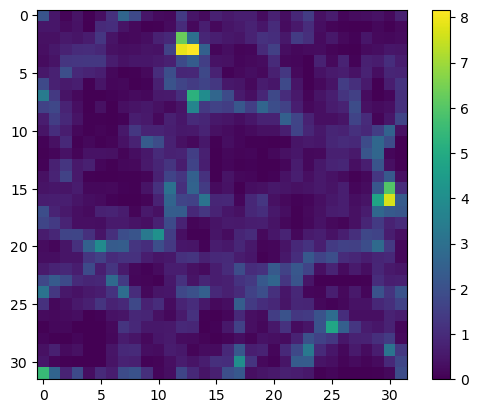

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(batch[0][0,0,0])
plt.colorbar()

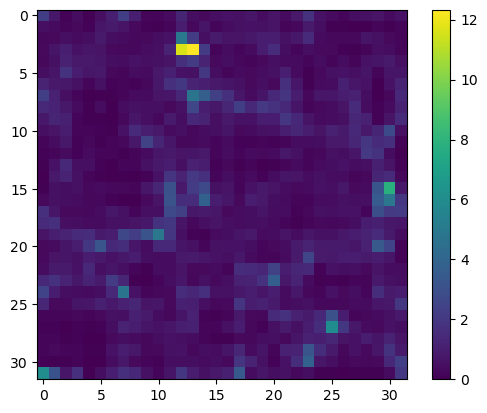

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(batch[1][0,0,0])
plt.colorbar()

In [ ]:
import torch
import lightning.pytorch as pl
from model import Lpt2NbodyNetLightning
import yaml
file_path = '/home/user/ckwan1/ml/configs/new_config/score_model_adam_gc_reverse_init_density_individual_std1and2.yaml'
with open(file_path, 'r') as file:
    config = yaml.safe_load(file)
config['model']['batch_size'] = config['data']['batch_size']
config['model']['max_epochs'] = config['trainer']['max_epochs']
config['model']['used_density'] = config['data']['density']
config['model']['ch_mult'] = [1]
model = Lpt2NbodyNetLightning(**config['model'])

optimizer = model.configure_optimizers()
x = torch.randn(1, 1, 32, 32, 32)
y = torch.randn(1, 1, 32, 32, 32)
# Forward pass
loss = model.training_step((x,y),batch_idx=0)

# Backward pass
loss.backward()

/home/user/ckwan1/.conda/envs/d3m/lib/python3.12/site-packages/lightning/pytorch/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
# from your_unet_file import StyledUNet3D # Make sure this import works
from unet import StyledUNet3D # Assuming unet.py is in the same directory or accessible

class MinimalLitModel(pl.LightningModule):
    def __init__(self, style_size, num_layers, base_filters, blocks_per_layer, init_dim, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters() # Saves init args to hparams

        self.model = StyledUNet3D(
            style_size=style_size,
            num_layers=num_layers,
            base_filters=base_filters,
            blocks_per_layer=blocks_per_layer,
            init_dim=init_dim
        )
        self.criterion = nn.MSELoss() # Example loss

    def forward(self, x, s):
        return self.model(x, s)

    def training_step(self, batch, batch_idx):
        x, s, y_true = batch # Assuming batch is (input_image, style_vector, target_image)
        y_pred = self(x, s)
        loss = self.criterion(y_pred, y_true)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

# Dummy DataModule (replace with your actual data)
class DummyDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=2, style_size=5, dim=32, init_dim=3):
        super().__init__()
        self.batch_size = batch_size
        self.style_size = style_size
        self.dim = dim
        self.init_dim = init_dim

    def train_dataloader(self):
        # Create dummy data that matches your model's expected input
        # (batch, channels, D, H, W) for x and y_true
        # (batch, style_size) for s
        x = torch.randn(self.batch_size, self.init_dim, self.dim, self.dim, self.dim)
        s = torch.randn(self.batch_size, self.style_size)
        y_true = torch.randn(self.batch_size, self.init_dim, self.dim, self.dim, self.dim) # Assuming output has same channels as input
        dataset = torch.utils.data.TensorDataset(x, s, y_true)
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size)

if __name__ == '__main__':
    # Model Hyperparameters (match what you used in the standalone test)
    style_size = 5
    num_layers = 2
    base_filters = 16
    blocks_per_layer = 1
    init_dim = 3

    lit_model = MinimalLitModel(
        style_size=style_size,
        num_layers=num_layers,
        base_filters=base_filters,
        blocks_per_layer=blocks_per_layer,
        init_dim=init_dim
    )

    # --- Check parameters within LightningModule context BEFORE training ---
    print("Parameters in LightningModule BEFORE Trainer.fit():")
    found_trainable_in_lit = False
    for name, param in lit_model.named_parameters(): # This will include model params
        if param.requires_grad:
            print(f"  {name} - requires_grad: {param.requires_grad}")
            found_trainable_in_lit = True
    if not found_trainable_in_lit:
        print("  ERROR: No trainable parameters found in LightningModule instance before fit!")
    else:
        print("  OK: Trainable parameters found in LightningModule instance before fit.")
    # --- End Check ---


    data_module = DummyDataModule(batch_size=2, style_size=style_size, init_dim=init_dim)

    # Configure Trainer for DDP (adjust accelerator and devices as needed)
    # Make sure you have at least 2 GPUs available or use 'ddp_spawn' for CPU testing
    # For CPU testing of DDP logic (slower):
    # trainer = pl.Trainer(max_epochs=1, strategy='ddp_spawn', accelerator='cpu', devices=2)

    # For GPU:
    trainer = pl.Trainer(
        max_epochs=1,
        accelerator='cpu',
        devices=2, # Use 1 for initial testing, then try 2 if you have them
        strategy='ddp_notebook'
        # strategy='ddp' # Simpler DDP
    )
    trainer.fit(lit_model, datamodule=data_module)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Parameters in LightningModule BEFORE Trainer.fit():
  model.encoders.0.0.conv.style_weight - requires_grad: True
  model.encoders.0.0.conv.style_bias - requires_grad: True
  model.encoders.0.0.conv.weight - requires_grad: True
  model.encoders.0.0.conv.bias - requires_grad: True
  model.encoders.0.0.bn.weight - requires_grad: True
  model.encoders.0.0.bn.bias - requires_grad: True
  model.encoders.1.0.conv.style_weight - requires_grad: True
  model.encoders.1.0.conv.style_bias - requires_grad: True
  model.encoders.1.0.conv.weight - requires_grad: True
  model.encoders.1.0.conv.bias - requires_grad: True
  model.encoders.1.0.bn.weight - requires_grad: True
  model.encoders.1.0.bn.bias - requires_grad: True
  model.encoders.2.0.conv.style_weight - requires_grad: True
  model.encoders.2.0.conv.style_bias - requires_grad: True
  model.encoders.2.0.conv.weight - requires_grad: True
  model.encoders.2.0.conv.bias - requires_grad: True
  model.encoders.2.0.bn.weight - requires_grad: True
  m

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

W0525 18:34:40.228000 1200725 site-packages/torch/multiprocessing/spawn.py:160] Terminating process 1203027 via signal SIGTERM


ProcessExitedException: process 1 terminated with signal SIGSEGV